<a href="https://colab.research.google.com/github/mahiro113/moq_opt/blob/main/tumbler_moq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#タンブラー在庫回転シュミレーション

月平均販売個数をもとに現在の在庫を残り在庫月数に変換  
どれかが残り在庫月数が１になったら発注、その際発注する個数は以下の条件  

各色１００個単位の発注  
合計６００個以上  

発注の時は各色の在庫月数の平均偏差を最小化するように発注する。

# 必要なパッケージ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install pulp
import pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 42.5 MB/s eta 0:00:00


# 関数

In [2]:
# 平均偏差を最小化する関数
def hattyuu(stock:list[int],sales_per_month:list[int],stock_zero_index:int) -> list[int]:

  # 問題の定義
  prob = pulp.LpProblem('tumblur_min', pulp.LpMinimize)

  # 発注個数の変数と制御用の変数
  x = [pulp.LpVariable(f"x{i}", lowBound=0,cat=pulp.LpInteger) for i in range(len(stock))]
  a = [pulp.LpVariable(f"a{i}", lowBound=0,cat=pulp.LpInteger) for i in range(len(stock))]

  # 絶対偏差の変数
  deviations = [pulp.LpVariable(f"deviation{i}", lowBound=0) for i in range(len(stock))]

  # 目的関数の係数を計算
  coeff = 1.0 / len(stock)

  # 平均値の部分を計算
  average_expr = pulp.lpSum([(stock[i] + x[i]) / sales_per_month[i] for i in range(len(stock))]) * coeff

  # 目的関数
  prob += pulp.lpSum(deviations)

  # 制約：絶対偏差の定義
  for i in range(len(stock)):
    prob += deviations[i] >= (stock[i] + x[i]) / sales_per_month[i] - average_expr
    prob += deviations[i] >= average_expr - (stock[i] + x[i]) / sales_per_month[i]

  prob += pulp.lpSum(a) <= 6
  prob += pulp.lpSum(x) >= 600
  prob += x[stock_zero_index] >= 100

  for i in range(len(stock)):
    prob += x[i] == 100*a[i]

  # 問題を解く
  prob.solve()

  # 結果の表示
  print('Status:', pulp.LpStatus[prob.status])
  for v in prob.variables():
      print(v.name, '=', v.varValue)

  return  [i.value() for i in x]




In [3]:
def simulater(tumbler_df,sales_per_month,T):
  stock = tumbler_df.iloc[0].to_numpy()
  # 月ごとの売上
  hattyu_count = 0

  for a in range(1,T):

    stock = stock - sales_per_month
    #在庫がマイナスになったらその在庫は１００補充
    if np.any(stock < 0):
      print(a,"月後に発注")
      hattyu_count += 1
      stock = np.add(stock,hattyuu(stock,sales_per_month,np.argmin(stock)))

    tumbler_df.loc[a] = stock.tolist()

  print(f"{hattyu_count}回発注しました")

  return tumbler_df

# 現在の場合


6 月後に発注
Status: Optimal
a0 = 2.0
a1 = 3.0
a2 = 1.0
a3 = 0.0
a4 = 0.0
deviation0 = 6.5791667
deviation1 = 2.8458333
deviation2 = 29.016667
deviation3 = 14.420833
deviation4 = 24.020833
x0 = 200.0
x1 = 300.0
x2 = 100.0
x3 = 0.0
x4 = 0.0
12 月後に発注
Status: Optimal
a0 = 1.0
a1 = 1.0
a2 = 4.0
a3 = 0.0
a4 = 0.0
deviation0 = 1.4839286
deviation1 = 5.3696429
deviation2 = 13.207143
deviation3 = 5.2303571
deviation4 = 14.830357
x0 = 100.0
x1 = 100.0
x2 = 400.0
x3 = 0.0
x4 = 0.0
37 月後に発注
Status: Optimal
a0 = 1.0
a1 = 2.0
a2 = 3.0
a3 = 0.0
a4 = 0.0
deviation0 = 3.5279762
deviation1 = 1.310119
deviation2 = 3.7309524
deviation3 = 4.0434524
deviation4 = 5.5565476
x0 = 100.0
x1 = 200.0
x2 = 300.0
x3 = 0.0
x4 = 0.0
56 月後に発注
Status: Optimal
a0 = 1.0
a1 = 2.0
a2 = 2.0
a3 = 1.0
a4 = 0.0
deviation0 = 5.789881
deviation1 = 0.0005952381
deviation2 = 3.2547619
deviation3 = 3.9327381
deviation4 = 6.4672619
x0 = 100.0
x1 = 200.0
x2 = 200.0
x3 = 100.0
x4 = 0.0
65 月後に発注
Status: Optimal
a0 = 1.0
a1 = 2.0
a2 = 2.0
a3

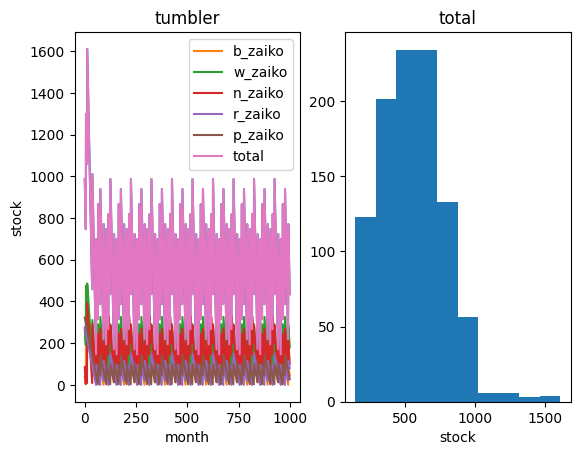

In [4]:
#各色の初期の在庫と月平均販売個数を定義
b_zaiko = 38
w_zaiko = 266
n_zaiko = 85
r_zaiko = 275
p_zaiko = 323

df_zaiko = pd.DataFrame(data = [{"b_zaiko":b_zaiko,"w_zaiko":w_zaiko,"n_zaiko":n_zaiko,"r_zaiko":r_zaiko,"p_zaiko":p_zaiko}])

#月の売上各色どのくらいか
sales_per_month = np.array([7, 15, 16, 5, 5])

df_zaiko = simulater(df_zaiko,sales_per_month,1000)

df_zaiko['total'] = df_zaiko.sum(axis=1)
plt.subplot(1,2,1)
plt.plot(df_zaiko['total'])
for i in df_zaiko.columns:
  plt.plot(df_zaiko[i],label=i)

plt.legend()

plt.xlabel("month")
plt.ylabel("stock")
plt.title("tumbler")

plt.subplot(1,2,2)
plt.hist(df_zaiko['total'])
plt.xlabel("stock")
plt.title("total")
print("平均トータル在庫数",df_zaiko['total'].mean())

# 色追加の場合

1 月後に発注
Status: Optimal
a0 = 2.0
a1 = 1.0
a2 = 0.0
a3 = 0.0
a4 = 0.0
a5 = 3.0
deviation0 = 2.8020833
deviation1 = 12.402083
deviation2 = 31.489583
deviation3 = 18.197917
deviation4 = 27.797917
deviation5 = 0.69791667
x0 = 200.0
x1 = 100.0
x2 = 0.0
x3 = 0.0
x4 = 0.0
x5 = 300.0
6 月後に発注
Status: Optimal
a0 = 0.0
a1 = 2.0
a2 = 4.0
a3 = 0.0
a4 = 0.0
a5 = 0.0
deviation0 = 9.1909722
deviation1 = 5.4576389
deviation2 = 12.878472
deviation3 = 11.809028
deviation4 = 21.409028
deviation5 = 5.6909722
x0 = 0.0
x1 = 200.0
x2 = 400.0
x3 = 0.0
x4 = 0.0
x5 = 0.0
31 月後に発注
Status: Optimal
a0 = 1.0
a1 = 2.0
a2 = 2.0
a3 = 0.0
a4 = 0.0
a5 = 1.0
deviation0 = 3.6750992
deviation1 = 0.89414683
deviation2 = 9.1483135
deviation3 = 3.0391865
deviation4 = 12.639187
deviation5 = 1.9608135
x0 = 100.0
x1 = 200.0
x2 = 200.0
x3 = 0.0
x4 = 0.0
x5 = 100.0
43 月後に発注
Status: Optimal
a0 = 1.0
a1 = 1.0
a2 = 3.0
a3 = 0.0
a4 = 0.0
a5 = 1.0
deviation0 = 1.9102183
deviation1 = 2.927877
deviation2 = 0.90128968
deviation3 = 5.661210

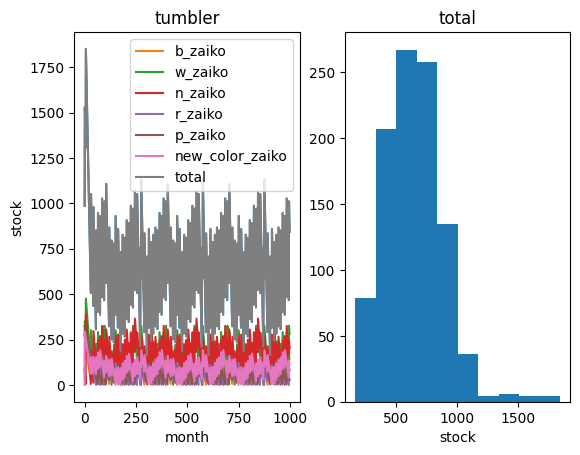

In [5]:
#各色の初期の在庫と月平均販売個数を定義
b_zaiko = 38
w_zaiko = 266
n_zaiko = 85
r_zaiko = 275
p_zaiko = 323
new_color_zaiko = 0

df_new_zaiko = pd.DataFrame(data = [{"b_zaiko":b_zaiko,"w_zaiko":w_zaiko,"n_zaiko":n_zaiko,"r_zaiko":r_zaiko,"p_zaiko":p_zaiko,"new_color_zaiko":new_color_zaiko}])

#月の売上各色どのくらいか
sales_per_month = np.array([7, 15, 16, 5, 5,8])

df_new_zaiko = simulater(df_new_zaiko,sales_per_month,1000)

df_new_zaiko['total'] = df_new_zaiko.sum(axis=1)
plt.subplot(1,2,1)
plt.plot(df_new_zaiko['total'])
for i in df_new_zaiko.columns:
  plt.plot(df_new_zaiko[i],label=i)

plt.legend()

plt.xlabel("month")
plt.ylabel("stock")
plt.title("tumbler")

plt.subplot(1,2,2)
plt.hist(df_new_zaiko['total'])
plt.xlabel("stock")
plt.title("total")
print("平均トータル在庫数",df_new_zaiko['total'].mean())